In [1]:
import pandas as pd; from shapely.geometry import Point, shape, Polygon;import fiona
from matplotlib import pyplot as plt ; from matplotlib import cm
%matplotlib inline
import numpy as np; import numpy.ma as ma; from matplotlib.patches import Path, PathPatch
from shapely.ops import unary_union, cascaded_union; from geopandas.tools import sjoin
import geopandas as gpd; import glob; import os; from datetime import timedelta, date;
from netCDF4 import Dataset
import scipy.ndimage; from cartopy import crs as ccrs; from cartopy.io.shapereader import Reader
import matplotlib.path as mpath; import seaborn as sns
import xarray as xr
import datetime as dt
import matplotlib
import mne
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz.utils import center_cmap
from matplotlib.colors import Normalize
from matplotlib import colors
#import dill

In [2]:
# Find index of points on a gridded array
# stn_lon,stn_lat = list of lat lon points --> lat_list, lon_list = [x1,x2][y1,y2]
# wrf_lon, wrf_lat = np.array of gridded lat lon --> grid_x= np.array([x1,x2,x3],[x4,x5,x6])
def find_index(stn_lon, stn_lat, wrf_lon, wrf_lat):
 # stn -- points in a list (list, can be a list of just 1) 
 # wrf -- gridded wrf lat/lon (np.array)
 #for iz in range(1):
    xx=[];yy=[]
    for i in range(len(stn_lat)):
       abslat = np.abs(wrf_lat-stn_lat[i])
       abslon= np.abs(wrf_lon-stn_lon[i])
       c = np.maximum(abslon,abslat)
       latlon_idx = np.argmin(c)
       x, y = np.where(c == np.min(c))
       #add indices of nearest wrf point station
       xx.append(x)
       yy.append(y)
    #
    xx=[xx[i][0] for i in range(len(xx))];yy=[yy[i][0] for i in range(len(yy))]
    #return indices list
    return xx, yy

In [3]:
def crop_array(x1,y1,x2,y2,x3,y3,x4,y4,lon,lat,gridded_var):
#''''''''''''''''''''''
# x1,y1,x2,y2,x3,y3,x4,y4 = indices of corners of cropping function
# lon,lat,gridded_var = grid of lons, lats, and variable
#''''''''''''''''''''''
#for i in range(1):
    # Make box around chicago to cut data -- specific for satellite, check to make sure the arrays are increasing in size
    # converting lat lon corners to index corners
    #set up zeros array given the bounds
    diffy =max(y1i,y2i,y3i,y4i)[0]-min(y1i,y2i,y3i,y4i)[0]
    diffx=max(x1i,x2i,x3i,x4i)[0]-min(x1i,x2i,x3i,x4i)[0]
    zlon,zlat,z=np.zeros([diffx, diffy]), np.zeros([diffx, diffy]), np.zeros([diffx, diffy])
    # fill out zeros array from the gridded data
    for i in range(diffx):
       for j in range(diffy):
          z[i][j]= gridded_var[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
          zlat[i][j]= lat[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
          zlon[i][j]= lon[min(x1i,x2i,x3i,x4i)[0]+i][min(y1i,y2i,y3i,y4i)[0]+j]
    #return values
    return zlon,zlat,z

In [4]:
# Lat and lon for smoke files
lat_lon = '/projects/b1045/jschnell/ForAmy/latlon_ChicagoLADCO_d03.nc'
ll=Dataset(lat_lon)
lat,lon=ll['lat'][:],ll['lon'][:]

In [5]:
# define statics
dir_CMAQ='/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_BASE_FINAL_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_mun = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noMUNI_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_bus = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noBUS_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_school = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noSCHOOL_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_no_school_ldv = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noSCHOOLplusLDV_1.33km_sf_rrtmg_5_8_1_v3852/postprocess/'
dir_ldv_wint = '/projects/b1045/wrf-cmaq/output/Chicago_LADCO/output_Amy_noSCHOOLplusLDV_wint_1.33km_sf_rrtmg_5_8_1_v3852/postprocess'
path = '/home/alr4786/geo_export_2f188c58-0852-485a-8c23-29a5272d17d1.shp'
chi  = gpd.GeoDataFrame.from_file(path)
var=['O3','NO2','PM25_TOT']
buffer = 0.1

In [6]:
#Read in cmaq files
cmaq_files=[]
for file in glob.glob(dir_CMAQ+'COMBINE_ACONC*'):
    cmaq_files.append(file)
cmaq_files.sort();
base=[Dataset(cmaq_files[i]) for i in range(len(cmaq_files))]


# Read in no municipal scenario files
no_mun_files=[]
for file in glob.glob(dir_no_mun+'COMBINE_ACONC*'):
    no_mun_files.append(file)
no_mun_files.sort();
no_mun=[Dataset(no_mun_files[i]) for i in range(len(no_mun_files))]


In [8]:
# Read in no bus scenario files
no_bus_files=[]
for file in glob.glob(dir_no_bus+'COMBINE_ACONC*'):
    no_bus_files.append(file)
no_bus_files.sort();
no_bus=[Dataset(no_bus_files[i]) for i in range(len(no_bus_files))]

# Read in no school bus scenario files
no_school_files=[]
for file in glob.glob(dir_no_school+'COMBINE_ACONC*'):
    no_school_files.append(file)
no_school_files.sort();
no_school=[Dataset(no_school_files[i]) for i in range(len(no_school_files))]

In [16]:
# Read in no school ldv scenario files
no_school_ldv_files=[]
for file in glob.glob(dir_no_school_ldv+'COMBINE_ACONC*'):
    no_school_ldv_files.append(file)
no_school_ldv_files.sort();
no_school_ldv=[Dataset(no_school_ldv_files[i]) for i in range(len(no_school_ldv_files))]

In [ ]:
# start cropping
var_crop = [[] for i in range(len(var))]
# s.t. --> o3_crop,no2_crop,pm25_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop CMAQ variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(base-1)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(base[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop[i].append(z)

In [9]:
# start cropping
var_crop = [[] for i in range(len(var))]
# s.t. --> o3_crop,no2_crop,pm25_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop CMAQ variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(base-1)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(base[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop[i].append(z)

In [17]:
# start cropping
var_crop_ldv = [[] for i in range(len(var))]
# s.t. --> o3_crop,no2_crop,pm25_crop = var_crop[0],var_crop[1],var_crop[2]
# s.t. --> variable at given day/hour = var_crop[variable][day*hour]


x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))
    #
# crop CMAQ variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(base)): #cmaq_ncfile
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_school_ldv[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_ldv[i].append(z)

In [18]:
%store var_crop
%store var_crop_ldv

Stored 'var_crop' (list)
Stored 'var_crop_ldv' (list)


In [11]:
# start cropping
var_crop_no_mun = [[] for i in range(len(var))]

x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))

# crop no_mun variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(no_mun)): #no_mun files
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_mun[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_no_mun[i].append(z)

In [8]:
%store -r var_crop
%store -r var_crop_no_mun
%store -r zlon
%store -r zlat
%store -r var_crop_no_bus
%store -r var_crop_no_school
%store -r var_crop_ldv

In [3]:
# start cropping
var_crop_no_bus = [[] for i in range(len(var))]

x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))


# crop no_mun variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(no_bus)): #no_bus files
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_bus[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_no_bus[i].append(z)

NameError: name 'var' is not defined

In [4]:
# start cropping
var_crop_no_school = [[] for i in range(len(var))]

x1,y1,x2,y2,x3,y3,x4,y4=[min(chi.bounds.minx)-buffer],[min(chi.bounds.miny)-buffer],[max(chi.bounds.maxx)+ buffer],[max(chi.bounds.maxy+.05)],[min(chi.bounds.minx-buffer)],[max(chi.bounds.maxy+ buffer)],[max(chi.bounds.maxx)+.05],[min(chi.bounds.miny)-buffer]
# convert from lat lon to indices
x1i,y1i=find_index([x1],[y1], np.array(lon), np.array (lat))
x2i,y2i=find_index([x2],[y2],np.array(lon), np.array (lat))
x3i,y3i=find_index([x3],[y3],np.array(lon), np.array (lat))
x4i,y4i=find_index([x4],[y4],np.array(lon), np.array (lat))


# crop no_mun variables
for i in range(len(var)):
# go through datasets and crop away
    for j in range(len(no_school)): #no_bus files
        for h in range(24):
            # note: this cmaq file requires an additional indexing bc of masked array ... could be different for different files
            lon,lat,gridded_var= lon,lat, np.array(no_school[j][var[i]][h][0])
            zlon,zlat,z = crop_array(x1i,y1i,x2i,y2i,x3i,y3i,x4i,y4i,lon,lat,gridded_var)
            var_crop_no_school[i].append(z)

NameError: name 'find_index' is not defined

In [13]:
# get shape outside
union=gpd.GeoSeries(unary_union(chi.geometry))
outsideofunion=pd.DataFrame([list(union[0][2].exterior.xy)[0], list(union[0][2].exterior.xy)[1]])

## Weekend vs Weekday

In [15]:
#'''''''''''''''''''''''''''''''''
def hourly_average(hour,days,var_crop,var):
#'''''''''''''''''''''''''''''''''
# hours = list of hours. ex: [6,7,8,9]
# days = list of indices, or indices of specific dates you want to pull **MUST BE INDEX NOT DATE
# var = list of variables. ex: ['O3']
#
    avg=[[] for i in range(len(var))]
    for v in range(len(var)):
        tmp =[var_crop[v][day*24+hour[hr]] for day in days for hr in range(len(hours))]
        avg[v]=np.average(tmp,axis=0)
#return list avg
    return avg

In [21]:
week = [1,2,3,6,7,8,9,10,13,14,15,16,17,20,21,22,23,24,27,28,29,30,31]
weekend = [4,5,11,12,18,19,25,26]
var_list= ['O3', 'NO2','PM25_TOT']
hours = range(24)

weekday_av = hourly_average(hours, week, var_crop, var_list)
weekend_av = hourly_average(hours, weekend, var_crop, var_list)

In [38]:
o3_week_dif = weekend_av[0]-weekday_av[0]
o3_week_dif.max().max(), o3_week_dif.min().min()

no2_week_dif = weekend_av[1]-weekday_av[1]
no2_week_dif.max().max(), no2_week_dif.min().min()

(2.646270952173982, -6.018689582637254)

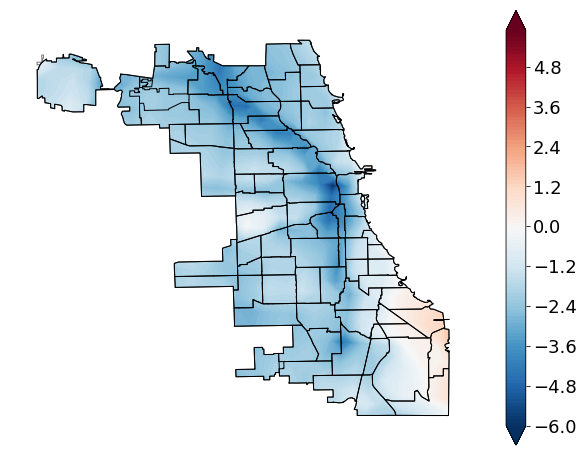

In [39]:
# Plot projection
crs_new = ccrs. AlbersEqualArea(central_longitude=(chi.bounds.mean().minx+chi.bounds.mean().maxx)/2)

# make fig object
%matplotlib inline

fig, axs1 = plt.subplots(1,1,subplot_kw={'projection': crs_new},figsize=(12, 8))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,no2_week_dif, transform=crs_new, levels=np.arange(-6,6,0.1),extend = 'both',
                  cmap = 'RdBu_r')
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)

#add colorbar and label
cbar1 = plt.colorbar(cs1, ax = axs1,fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 

## Monthly Averages

In [11]:
pm = [base[i]['PM25_TOT'][j][0] for i in range(len(base)) for j in range(24)]

In [12]:
pm_av = np.average(base[1]['PM25_TOT'][:].data, axis = 0)

In [9]:
av_o3 = (np.average(var_crop[0], axis = 0))
av_no2 = (np.average(var_crop[1], axis = 0))
av_pm = (np.average(var_crop[2], axis = 0))

av_o3_nb = (np.average(var_crop_no_bus[0], axis = 0))
av_no2_nb = (np.average(var_crop_no_bus[1], axis = 0))
av_pm_nb = (np.average(var_crop_no_bus[2], axis = 0))

av_o3_ns = (np.average(var_crop_no_school[0], axis = 0))
av_no2_ns = (np.average(var_crop_no_school[1], axis = 0))
av_pm_ns = (np.average(var_crop_no_school[2], axis = 0))

av_o3_ns_ldv = (np.average(var_crop_ldv[0], axis = 0))
av_no2_ns_ldv = (np.average(var_crop_ldv[1], axis = 0))
av_pm_ns_ldv = (np.average(var_crop_ldv[2], axis = 0))

av_o3_nm = (np.average(var_crop_no_mun[0], axis = 0))
av_no2_nm = (np.average(var_crop_no_mun[1], axis = 0))
av_pm_nm = (np.average(var_crop_no_mun[2], axis = 0))

In [10]:
o3_dif =  (av_o3_nm - av_o3)
no2_dif = (av_no2_nm - av_no2)
pm_dif = (av_pm_nm - av_pm)

o3_dif_nbus =  (av_o3_nb - av_o3)
no2_dif_nbus = (av_no2_nb - av_no2)
pm_dif_nbus = (av_pm_nb - av_pm)

o3_dif_nschool =  (av_o3_ns - av_o3)
no2_dif_nschool = (av_no2_ns - av_no2)
pm_dif_nschool = (av_pm_ns - av_pm) 

o3_dif_ldv =  (av_o3_ns_ldv - av_o3)
no2_dif_ldv = (av_no2_ns_ldv - av_no2)
pm_dif_ldv = (av_pm_ns_ldv - av_pm)  

In [ ]:
avs = [av_o3, av_no2, av_pm, av_o3_nb, av_no2_nb, av_pm_nb,
       av_o3_ns, av_no2_ns, av_pm_ns,av_o3_ns_ldv, av_no2_ns_ldv, av_pm_ns_ldv]
difs = [o3_dif, no2_dif, pm_dif, o3_dif_nbus,no2_dif_nbus,pm_dif_nbus,o3_dif_nschool,no2_dif_nschool,
       pm_dif_nschool,o3_dif_ldv,no2_dif_ldv, pm_dif_ldv]
avs_name = ["av_o3", "av_no2", "av_pm", "av_o3_nb", "av_no2_nb", "av_pm_nb",
       "av_o3_ns", "av_no2_ns", "av_pm_ns","av_o3_ns_ldv", "av_no2_ns_ldv", "av_pm_ns_ldv"]

In [34]:
def monthly_mean_val(value):
    out = []
    for i in value:
        out.append(i.mean().mean())
        
    return out

In [35]:
monthly_mean_val(difs)

[0.36706910629988426,
 -0.9921764395909142,
 -0.2518668151351389,
 0.10053789051542435,
 -0.3852956713523418,
 -0.06809300411975175,
 0.25377879983869717,
 -0.718967982388564,
 -0.30953591935791097,
 0.12428342188649652,
 -0.5924251775452413,
 -0.20213977849085016]

In [11]:
def mask_array(input_arr, output_arr): 
    for i in range(len(input_arr)): 
        output_arr.append(input_arr[i]*mask)
        
    return output_arr

In [13]:
mask = mask_given_shapefile(zlon, zlat, chi)
masked_base, masked_nbus, masked_nschool = [], [], []

base_avgs = [av_no2, av_o3, av_pm]
nbus_avgs= [no2_dif_nbus, o3_dif_nbus, pm_dif_nbus]
nschool_avgs = [no2_dif_nschool, o3_dif_nschool, pm_dif_nschool]

base_mask = mask_array(base_avgs, masked_base)
nbus_mask = mask_array(nbus_avgs, masked_nbus)
nschool_mask = mask_array(nschool_avgs, masked_nschool)

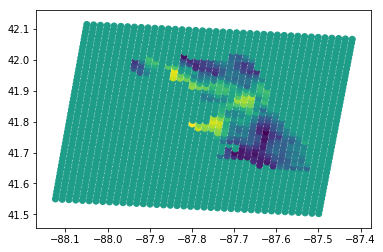

In [14]:
plt.scatter(zlon, zlat, c = nschool_mask[2])

In [18]:
av_pm.to_csv('base_av_pm.csv')
pm_dif_nbus.to_csv('no_bus_pm.csv')
pm_dif_nschool.to_csv('no_school_pm.csv')

In [19]:
len(lon)

288

## Plotting

In [11]:
# Plot projection
crs_new = ccrs. AlbersEqualArea(central_longitude=(chi.bounds.mean().minx+chi.bounds.mean().maxx)/2)

In [30]:
# Calculate levels for plotting 
monthly_avs = [av_o3, av_no2, av_pm]
maxs = []
mins = []
for i in range(len(monthly_avs)):
    maxs.append(monthly_avs[i].max().max())
    mins.append(monthly_avs[i].min().min())

no2_level = np.arange(9, 30, 0.25)
o3_level = np.arange(27, 47 ,0.25)
pm_level = np.arange(7, 15, .15)

In [31]:
mins, maxs

([26.39179553289432, 4.772952062776312, 6.290435877629837],
 [48.31165649307271, 30.795874419932563, 19.25965534336865])

Text(0, 0.5, 'μg/$m^3$')

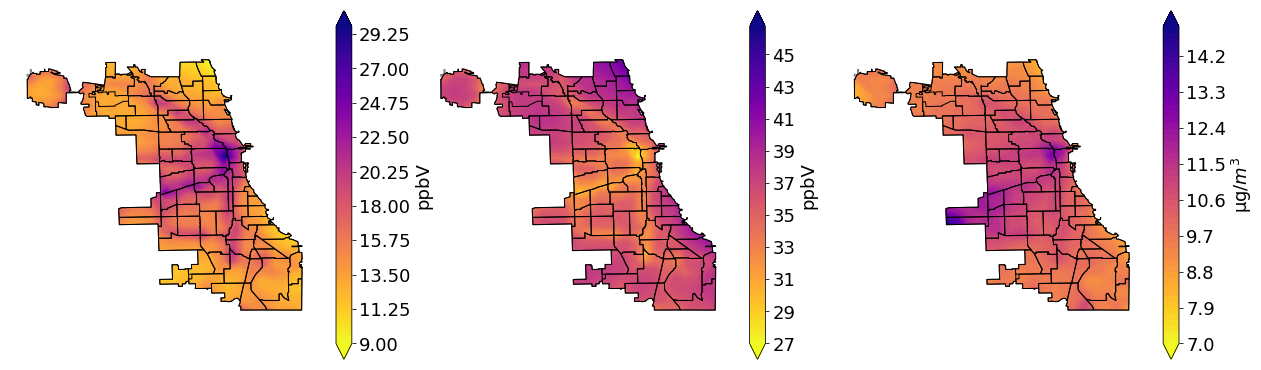

In [32]:
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

# make fig object
%matplotlib inline

fig, (axs1, axs2, axs3) = plt.subplots(1,3,subplot_kw={'projection': crs_new},figsize=(21, 12))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,av_no2, transform=crs_new, levels=no2_level, cmap = "plasma_r", extend = 'both')
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


# OZONE PLOT
chi.plot(ax=axs2, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,av_o3, transform=crs_new, levels=o3_level, cmap = "plasma_r", extend = 'both')
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


# NO2 PLOT
chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon,zlat,av_pm, transform=crs_new, levels=pm_level, cmap = "plasma_r", extend = 'both')
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)

#add colorbar and label
cbar1 = plt.colorbar(cs1, ax = axs1,fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 
cbar2 = plt.colorbar(cs2, ax = axs2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 
cbar3 = plt.colorbar(cs3, ax = axs3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 
cbar1.ax.set_ylabel('ppbV', size = 18)
cbar2.ax.set_ylabel('ppbV', size = 18)
cbar3.ax.set_ylabel(u"\u03bcg/$m^3$", size = 18)


#cbar1.set_ticks(np.arange(mins[1], maxs[1], 10))


#fig.savefig("/home/alr4786/base_monthly_av.pdf")

In [24]:
# Calculate levels for plotting 
difs = [o3_dif, no2_dif, pm_dif]
dif_maxs = []
dif_mins = []
for i in range(len(difs)):
    dif_maxs.append(difs[i].max().max())
    dif_mins.append(np.nanmin(np.nanmin(difs[i])))
    
no2_dif_lev = np.arange(-.06,0.6, 0.075)
o3_dif_lev = np.arange(-0.6, 0.6, 0.075)
pm_dif_lev = np.arange(-.2, 0.2, 0.025)

In [25]:
dif_mins, dif_maxs

([-0.15511426981538534, -0.4800344950829931, -0.13103194915068705],
 [0.46132581766384817, 0.17017455926785985, 0.163725711211252])

In [17]:
cmap1 = center_cmap(plt.cm.RdBu_r, dif_mins[1],dif_maxs[1])
cmap2 = center_cmap(plt.cm.RdBu_r, dif_mins[0], dif_maxs[0])
cmap3 = center_cmap(plt.cm.RdBu_r, dif_mins[2], dif_maxs[2])

Text(0, 0.5, 'μg/$m^3$')

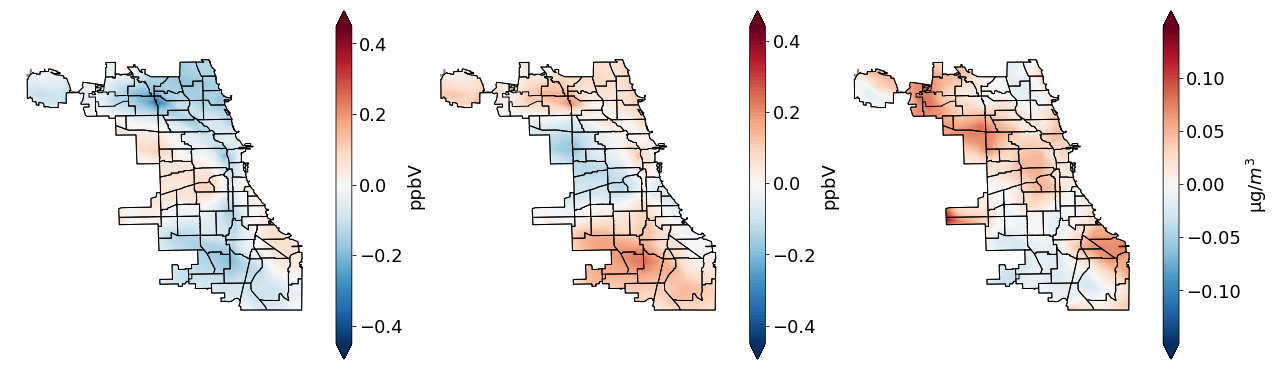

In [12]:
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

# make fig object
%matplotlib inline

fig, (axs1, axs2, axs3) = plt.subplots(1,3,subplot_kw={'projection': crs_new},figsize=(21, 12))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,no2_dif_nbus, transform=crs_new,levels=np.arange(-.45, .45, .0015),extend = 'both',
                  cmap = 'RdBu_r')
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs2, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,o3_dif_nbus, transform=crs_new, levels=np.arange(-.45,.45,.01),extend = 'both',
                  cmap = 'RdBu_r')
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon, zlat,pm_dif_nbus, transform=crs_new, levels=np.arange(-.15,.15,.0015), extend = 'both',
                  cmap = 'RdBu_r')
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


#add colorbar and label
cbar1 = plt.colorbar(cs1,ax = axs1,ticks = [-.4, -.2, 0, .2,.4], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 

cbar2 = plt.colorbar(cs2, ax = axs2, ticks = [-.4, -.2, 0,.2, 0.4], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 

cbar3 = plt.colorbar(cs3, ax = axs3,ticks = [ -.1, -0.05, 0, .05, .1],fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 

cbar1.ax.set_ylabel('ppbV', size = 18)
cbar2.ax.set_ylabel('ppbV', size = 18)
cbar3.ax.set_ylabel(u"\u03bcg/$m^3$", size = 18)


#fig.savefig("/home/alr4786/bus_monthly_av_dif.pdf")

## NO SCHOOL PLOTS

In [25]:
# Calculate levels for plotting 
difs = [o3_dif_nschool, no2_dif_nschool, pm_dif_nschool]
dif_maxs_ns = []
dif_mins_ns = []
for i in range(len(difs)):
    dif_maxs_ns.append(difs[i].max().max())
    dif_mins_ns.append(np.nanmin(np.nanmin(difs[i])))
    
no2_dif_lev = np.arange(-.4,0.4, 0.0075)
o3_dif_lev = np.arange(-0.3, 0.3, 0.0075)
pm_dif_lev = np.arange(-.2, 0.2, 0.0025)

In [26]:
cmap1 = center_cmap(plt.cm.RdBu_r, -.4,.4)
cmap2 = center_cmap(plt.cm.RdBu_r, -.3,.3)
cmap3 = center_cmap(plt.cm.RdBu_r,-.2,.2)

NameError: name 'no2_dif_nschool' is not defined

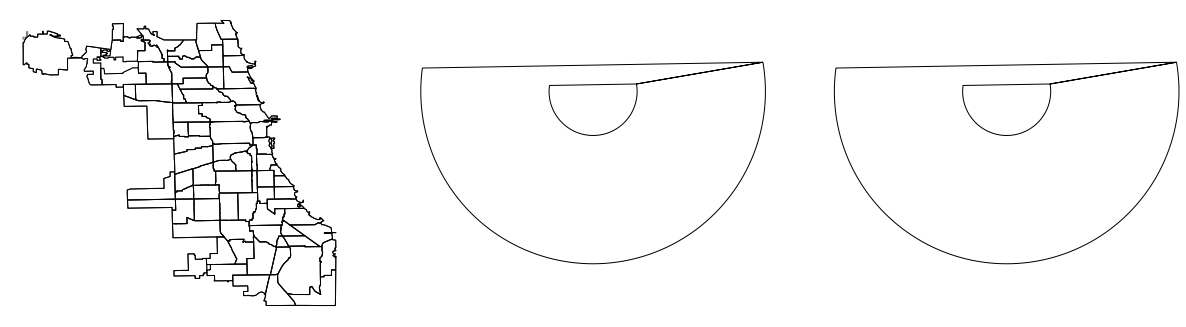

In [10]:
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

# make fig object
%matplotlib inline

fig, (axs1, axs2, axs3) = plt.subplots(1,3,subplot_kw={'projection': crs_new},figsize=(21, 12))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
#divnorm = colors.DivergingNorm(vmin=dif_mins[1], vcenter=0, vmax= dif_maxs[1])
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,no2_dif_nschool, transform=crs_new, levels=np.arange(-1.75, 1.75, .0015),extend = 'both', 
                  cmap = 'RdBu_r')
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs2, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,o3_dif_nschool, transform=crs_new, levels=np.arange(-.75, .75, .0015),extend = 'both', 
                  cmap = 'RdBu_r')
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon, zlat,pm_dif_nschool, transform=crs_new, levels=np.arange(-1, 1, .0015),extend = 'both', 
                  cmap = 'RdBu_r')
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


#add colorbar and label
cbar1 = plt.colorbar(cs1,ax = axs1,ticks = [-1.5, -1, -0.5, 0, .5, 1, 1.5], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 

cbar2 = plt.colorbar(cs2,ax = axs2,ticks = [-0.5, -.25, 0, 0.25, .5], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 

cbar3 = plt.colorbar(cs3, ax = axs3,ticks = [-0.75, -0.5, -0.25, 0, 0.25, .5, 0.75], fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 
cbar1.ax.set_ylabel('% Change', size = 18)
cbar2.ax.set_ylabel('% Change', size = 18)
cbar3.ax.set_ylabel("% Change", size = 18)

#divnorm = colors.DivergingNorm(vmin=vmin, vcenter=0, vmax= vmax)
#cs=plt.pcolormesh(plon,plat,data,cmap= cmap , transform=crs_new, vmin=vmin,vmax=vmax, norm=divnorm)

#fig.savefig("/home/alr4786/school_monthly_av_dif.pdf")

## SCHOOL LDV PLOTS

In [13]:
# Calculate levels for plotting 
difs = [o3_dif_ldv, no2_dif_ldv, pm_dif_ldv]
dif_maxs_ldv = []
dif_mins_ldv = []
for i in range(len(difs)):
    dif_maxs_ldv.append(difs[i].max().max())
    dif_mins_ldv.append(difs[i].min().min())
    
no2_dif_lev = np.arange(-1.5,1.5, 0.0075)
o3_dif_lev = np.arange(-1.5, 1.5, 0.0075)
pm_dif_lev = np.arange(-2, 1.5, 0.0025)

In [14]:
cmap1 = center_cmap(plt.cm.RdBu_r, -.4,0.4)
cmap2 = center_cmap(plt.cm.RdBu_r, -0.3, 0.3)
cmap3 = center_cmap(plt.cm.RdBu_r, -.2, 0.2)

Text(0, 0.5, '% Change')

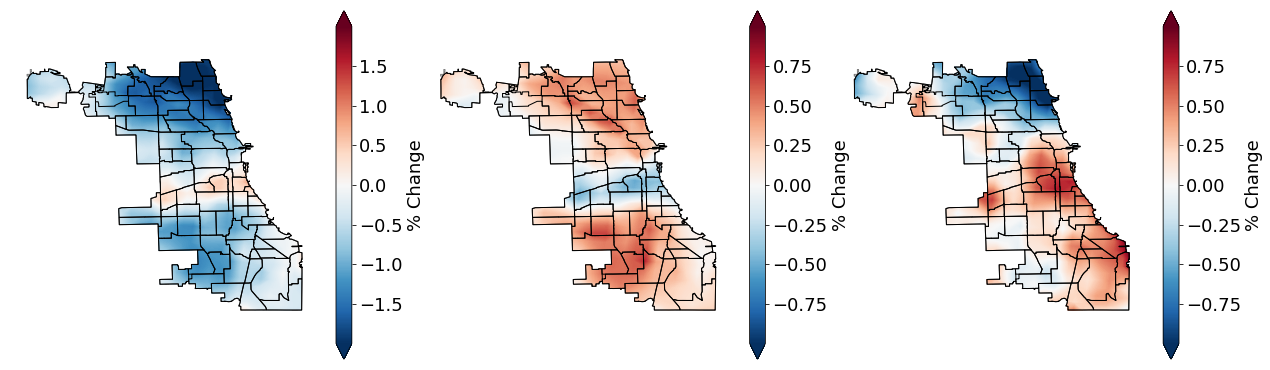

In [14]:
# set boundary as outer extent by making a matplotlib path object and adding that geometry
# i think setting the boundary before you plot the data actually crops the data to the shape, so set ax first

# make fig object
%matplotlib inline

fig, (axs1, axs2, axs3) = plt.subplots(1,3,subplot_kw={'projection': crs_new},figsize=(21, 12))

# NO2 Plot
chi.plot(ax=axs1, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs1.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs1.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs1=axs1.contourf(zlon,zlat,no2_dif_ldv, transform=crs_new, levels=np.arange(-2, 2, .0015),extend = 'both', 
                  cmap = 'RdBu_r')
x=[min(chi.bounds.minx), max(chi.bounds.maxx)] 
y=[min(chi.bounds.miny), max(chi.bounds.maxy)]
axs1.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs2, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs2.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs2.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs2=axs2.contourf(zlon,zlat,o3_dif_ldv, transform=crs_new, levels=np.arange(-1, 1, .0015),extend = 'both', 
                  cmap = 'RdBu_r')
axs2.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


chi.plot(ax=axs3, transform=crs_new, facecolor = 'None', edgecolor = 'grey')
axs3.set_boundary(mpath.Path(outsideofunion.T,closed=True), transform= crs_new, use_as_clip_path=True)
axs3.add_geometries(Reader(path).geometries(), crs=crs_new,facecolor='None', edgecolor='black')
cs3=axs3.contourf(zlon, zlat,pm_dif_ldv, transform=crs_new,levels=np.arange(-1, 1, .0015),extend = 'both', 
                  cmap = 'RdBu_r')
axs3.set_extent([x[0]-.03,x[1]+.03,y[0]-.03,y[1]+.03],crs= crs_new)


#add colorbar and label
cbar1 = plt.colorbar(cs1, ax = axs1,ticks = [-1.5,-1, -0.5, 0, 0.5, 1, 1.5],fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18) 
cbar2 = plt.colorbar(cs2, ax = axs2,ticks = [-.75, -0.5, -0.25, 0, 0.25, .5, 0.75], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18) 
cbar3 = plt.colorbar(cs3, ax = axs3,ticks = [-0.75, -0.5, -0.25, 0, 0.25, .5, 0.75], fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=18) 
cbar1.ax.set_ylabel('% Change', size = 18)
cbar2.ax.set_ylabel('% Change', size = 18)
cbar3.ax.set_ylabel("% Change", size = 18)


#fig.savefig("/home/alr4786/school_monthly_av_dif.pdf")